Assignment 2 made by:

Niels van den Hork - s4572602

Niels van Drueten - s4496604



In [54]:
from scipy.io import loadmat
from scipy import signal
import numpy as np
import json
import matplotlib.pyplot as plt
#!pip install tqdm
from tqdm import tqdm_notebook as tqdm #if running in a notebook
#from tqdm import tqdm as tqdm #if not running in a notebook
from scipy.stats.stats import pearsonr
#from numpy import correlate as corr #not pearson 


In [55]:
# PRESENT Cipher SBox
SBox = [0xC, 0x5, 0x6, 0xB, 0x9, 0x0, 0xA, 0xD, 0x3, 0xE, 0xF, 0x8, 0x4, 0x7, 0x1, 0x2]
SBox_inv = [0x5, 0xE, 0xF, 0x8, 0xC, 0x1, 0x2, 0xD, 0xB, 0x4, 0x6, 0x3, 0x0, 0x7, 0x9, 0xA]

# Function f is the intermediate result,
# where i is the known non-constant data value
# and k is a small part of the key.
def f(i, k):
    i1, i2 = i >> 4, i & 0x0F
    k1, k2 = k >> 4, k & 0x0F
    inv1, inv2 = SBox[i1] ^ k1, SBox[i2] ^ k2
    result = inv1 << 4 ^ inv2
    return result

# Function f_inv is the inverse of intermediate result,
# where o is the known non-constant data value
# and k is a small part of the key.
def f_inv(o, k):
    o1, o2 = o >> 4, o & 0x0F
    k1, k2 = k >> 4, k & 0x0F
    inv1, inv2 = SBox_inv[o1] ^ k1, SBox_inv[o2] ^ k2
    result = inv1 << 4 ^ inv2
    return result

# Returns the Hamming distance between val1 and val2.
def hd(val1,val2):
    return bin(val1 ^ val2).count("1")



In [56]:
# INPUT MATRIX WILL BE OF SIZE [no_inputs x no_keys]
# INSTEAD OF [no_inputs x 1]
def construct_input_matrix(output, key_len):
	input = np.zeros((len(output), 2**key_len), dtype="uint8")
	for i in range(len(output)):
		output_elem = output[i][0]
		for k in range(2**key_len):
			val = f_inv(output_elem,k)
			input[i][k] = val
	return input


In [57]:
# Returns a Power-Prediction Matrix of size [no_inputs x no_keys]
# Input _in: Value-Prediction Matrix of size [no_inputs x no_keys]
def construct_pow_pred_matrix(val_pred_matrix, od, key_len):
	output = np.zeros((len(_in), 2**key_len), dtype="uint8")
	for i in range(len(_in)):
		in_elem = _in[i][0]
		for k in range(2**key_len):
			val1 = val_pred_matrix[i][k]
			val2 = od[i][0]
			output[i][k] = hd(val1, val2)
	return output

In [58]:
# Uses the correlate function of the scipy io library,
# that cross-correlates two matrices.
def correlate_m(matrix1, matrix2):
    print("Correlating between: {} and {}".format(matrix1.shape,matrix2.shape))
    
    cols_matrix1 = matrix1.shape[1]
    cols_matrix2 = matrix2.shape[1]
    
    result = np.zeros((cols_matrix1,cols_matrix2))
    
    for j in tqdm(range(cols_matrix2)):
        for i in range(cols_matrix1):
            #result[i][j] = pearsonr(matrix1[:,i], matrix2[:,j])[0]
            result[i][j] = np.corrcoef(matrix1[:,i], matrix2[:,j])[0][1]
    return result


Here we load the traceset. There are 11 peaks as you would expect from AES. All traces are similar to eachother.

Input: 
 [[-54. -54. -51. ...  20.  22.  23.]
 [-56. -56. -52. ...  19.  22.  21.]
 [-42. -42. -49. ...  21.  20.  23.]
 ...
 [-54. -54. -51. ...  22.  21.  23.]
 [-56. -56. -52. ...  19.  21.  24.]
 [-45. -45. -48. ...  21.  22.  22.]] (10000, 2000)


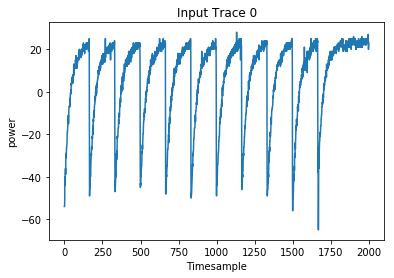

In [59]:
# Opens "hardware_traces.mat" file.
ht_file = loadmat('hardware_traces.mat')
ht = ht_file['traces'] #contains 10.000 traces, 2k samples each, 8bit(?) values

print("Input: \n {} {}".format(ht, ht.shape))

plt.plot(ht[0])
plt.title('Input Trace 0')
plt.xlabel('Timesample')
plt.ylabel('power')
plt.show()

Input: 
 [216  95 100 ... 207 235  72] (10000, 1)


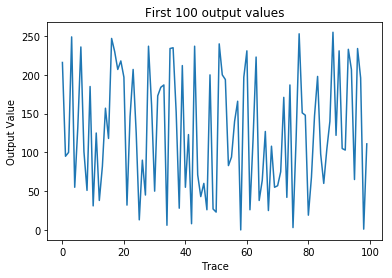

In [60]:
# Opens "output_data.mat" file.
od_file = loadmat('output_data.mat')
od = od_file['output_data'] #contains 10.000 output values, each 8bit

print("Input: \n {} {}".format(od[:,0], od.shape))

plt.plot(od[:100,0])
plt.title('First 100 output values')
plt.xlabel('Trace')
plt.ylabel('Output Value')
plt.show()

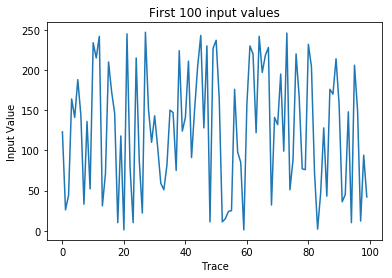

In [61]:
_in = construct_input_matrix(od, 8)
plt.plot(_in[:100,0])
plt.title('First 100 input values')
plt.xlabel('Trace')
plt.ylabel('Input Value')
plt.show()

Here we compute the power consumption that each (output value, key) pair would produce.
Instead of using an input value, like last time, we use the output value And this time these values are 8bit

Power prediction matrix: 
 [[4 3 3 ... 5 5 4]
 [3 2 4 ... 4 6 5]
 [2 3 3 ... 5 5 6]
 ...
 [4 3 5 ... 3 5 4]
 [4 5 5 ... 3 3 4]
 [3 2 2 ... 6 6 5]] (10000, 256)


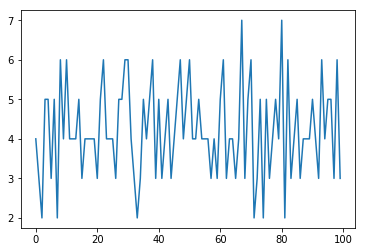

In [62]:
# Computing power prediction matrix
pow_pred_matrix = construct_pow_pred_matrix(_in, od, 8)
print("Power prediction matrix: \n {} {}".format(pow_pred_matrix, pow_pred_matrix.shape))

plt.plot(pow_pred_matrix[:100,0]) #first 100 input power for the first key (0)

Traces matrix: 
 [[-54. -54. -51. ...  20.  22.  23.]
 [-56. -56. -52. ...  19.  22.  21.]
 [-42. -42. -49. ...  21.  20.  23.]
 ...
 [-54. -54. -51. ...  22.  21.  23.]
 [-56. -56. -52. ...  19.  21.  24.]
 [-45. -45. -48. ...  21.  22.  22.]] (10000, 2000)


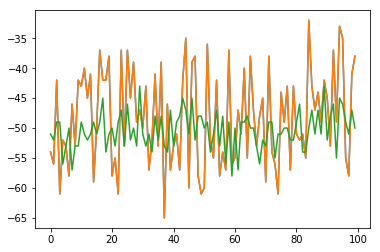

In [63]:
# Opens "traces.mat" file.
trace_file = loadmat('hardware_traces.mat')
_traces = trace_file['traces']
print("Traces matrix: \n {} {}".format(_traces, _traces.shape ))

plt.plot(_traces[:100,0])
plt.plot(_traces[:100,1])
plt.plot(_traces[:100,2])

In [64]:
result = correlate_m(pow_pred_matrix, _traces)
print(result.shape)

Correlating between: (10000, 256) and (10000, 2000)


(256, 2000)


In [65]:
def compute_best_key(result):
    key = 0
    value = 0
    for i in range(result.shape[0]):
        this_value = 0
        for j in range(result.shape[1]):
            this_value = abs(result[i][j])
            #print("key: {}, {} difference {}".format(i, this_value, value - this_value))
            if(this_value > value):
                #print("old value: {} with key: {}".format(value, i))
                value = this_value
                key = i
                print("new value: {} with key: {} (change: {})".format(value, i, this_value - value))
        
    return key, value

best_keyguess, value = compute_best_key(result)
print("Best key: {} with absolute value: {}".format(best_keyguess, value))
#best_keyguess = 35

new value: 0.0009508537255953944 with key: 0 (change: 0.0)
new value: 0.002015237854142815 with key: 0 (change: 0.0)
new value: 0.003660928442866543 with key: 0 (change: 0.0)
new value: 0.006859004729501394 with key: 0 (change: 0.0)
new value: 0.009515915387918192 with key: 0 (change: 0.0)
new value: 0.010803979547654632 with key: 0 (change: 0.0)
new value: 0.014824782295987281 with key: 0 (change: 0.0)
new value: 0.017337472060455807 with key: 0 (change: 0.0)
new value: 0.017528027100293348 with key: 0 (change: 0.0)
new value: 0.018373656041279104 with key: 0 (change: 0.0)
new value: 0.020309655060876505 with key: 0 (change: 0.0)
new value: 0.025246797055177603 with key: 0 (change: 0.0)
new value: 0.026449071565177812 with key: 0 (change: 0.0)
new value: 0.026766792873179398 with key: 0 (change: 0.0)
new value: 0.029061117909581997 with key: 0 (change: 0.0)
new value: 0.033781211211600354 with key: 0 (change: 0.0)
new value: 0.03454942457844301 with key: 0 (change: 0.0)
new value: 0.0

Text(0, 0.5, 'summed absolute correlation')

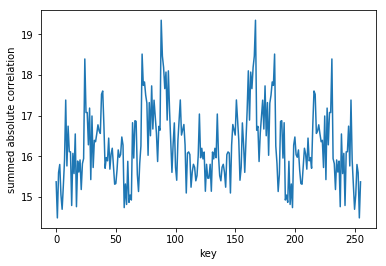

In [66]:
plt.plot([sum(list(map(abs,row))) for row in result])
plt.xlabel('key')
plt.ylabel('summed absolute correlation')

Text(0, 0.5, 'peak absolute correlation')

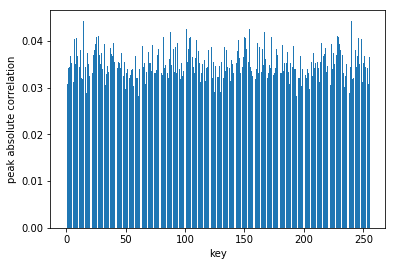

In [67]:
absresult = np.array([list(map(abs,row)) for row in result])
maxidx = np.argmax(absresult,axis=1)

maxconf = np.array([(row[0],midx,row[1][midx]) for row,midx in zip(enumerate(absresult),maxidx)])
smaxconf = np.array(sorted(maxconf,key = lambda x : -x[2]) )

#[print(e) for e in smaxconf]
    
plt.bar(range(256),maxconf[:,2] )
plt.xlabel('key')
plt.ylabel('peak absolute correlation')

Text(0, 0.5, 'absolute correlation')

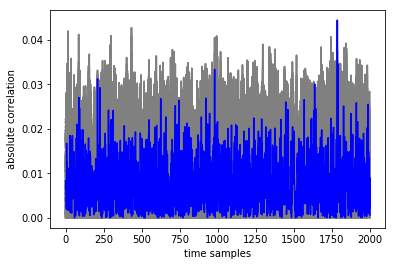

In [68]:
for i,row in enumerate(result):
    if i == best_keyguess:
        continue
    plt.plot(list(map(abs,row)),color='gray')
    
plt.plot(list(map(abs,result[best_keyguess])),color='blue')
plt.xlabel('time samples')
plt.ylabel('absolute correlation')

Correlating between: (500, 256) and (500, 2000)


best guess: 17.0
106
Correlating between: (1000, 256) and (1000, 2000)


best guess: 17.0
42
Correlating between: (2000, 256) and (2000, 2000)


best guess: 71.0
14
Correlating between: (4000, 256) and (4000, 2000)


best guess: 53.0
120
Correlating between: (8000, 256) and (8000, 2000)


best guess: 12.0
160
Correlating between: (10000, 256) and (10000, 2000)


best guess: 15.0
0


Text(0, 0.5, 'ranking (lower is better)')

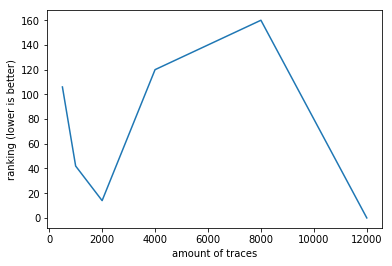

In [69]:
keyranking = []
for amount in [500,1000,2000,4000,8000,12000]:
    result = correlate_m(pow_pred_matrix[:amount], _traces[:amount])

    absresult = np.array([list(map(abs,row)) for row in result])
    maxidx = np.argmax(absresult,axis=1)
    maxconf = np.array([(row[0],midx,row[1][midx]) for row,midx in zip(enumerate(absresult),maxidx)])
    smaxconf = np.array(sorted(maxconf,key = lambda x : -x[2]) )
    #[print(e) for e in smaxconf]

    keyrank = np.array([e[0] for e in smaxconf])
    print("best guess: {}".format(keyrank[0]))
    best_keyguess = 15
    keyidx = np.where(keyrank == best_keyguess)[0][0]
    print(keyidx)
    keyranking.append(keyidx)

Text(0, 0.5, 'ranking (lower is better)')

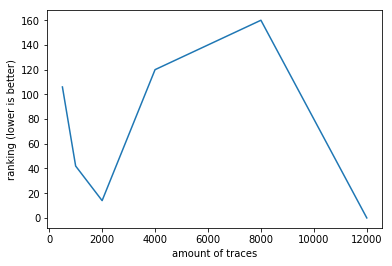

In [70]:
plt.plot(np.array([500,1000,2000,4000,8000,12000]),keyranking)   
plt.xlabel('amount of traces')
plt.ylabel('ranking (lower is better)')